In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 25s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
vif_result_df = pd.read_csv('./Production_Prep/vif10.csv')
print(vif_result_df.shape)
vif_result_df.head()

(15, 1)


,cols_to_drop
0,층max
1,총용적률연면적
2,전용면적_mean
3,토지면적
4,철근콘크리트구조_fraction


In [13]:
vif_cols_to_drop = vif_result_df['cols_to_drop'].tolist()
vif_cols_to_drop

['층max',
 '총용적률연면적',
 '전용면적_mean',
 '토지면적',
 '철근콘크리트구조_fraction',
 '총연면적',
 '총주차수',
 '공원자연환경지구',
 '전용면적_min',
 '상대보호구역',
 '체육공원',
 '광로2류(폭_50M~70M)',
 '전용면적_max',
 '층median',
 '중요시설물보호지구(공항)']

In [14]:
shap_summary_df = pd.read_csv(basedir + 'shap_summary_vif10.csv', index_col=[0])
print(shap_summary_df.shape)
shap_summary_df.head()

(384, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
전용면적,40.331355,39.865082,39.482899,37.147049,38.173221,38.999922
층,4.997734,5.332695,5.074623,4.923113,5.154233,5.096480
건축년도,47.650346,48.568973,48.951757,49.219809,45.867508,48.051679
건물나이,2.360354,2.379373,2.420130,2.422372,2.340672,2.384580
year_linear,64.570858,64.392019,62.660680,62.894452,63.028514,63.509304


In [15]:
zero_df = shap_summary_df[shap_summary_df['shap_summary_mean'] <= 0]
print(zero_df.shape)
zero_df.head()

(25, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
석구조_fraction,0.0,0.0,0.0,0.0,0.0,0.0
라멘조_fraction,0.0,0.0,0.0,0.0,0.0,0.0
조립식판넬조_fraction,0.0,0.0,0.0,0.0,0.0,0.0
주_용도_수련시설_fraction,0.0,0.0,0.0,0.0,0.0,0.0
주_용도_교육연구및복지시설_fraction,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
zero_cols = zero_df.index.tolist()
len(zero_cols)

25

In [17]:
zero_cols[:5]

['석구조_fraction',
 '라멘조_fraction',
 '조립식판넬조_fraction',
 '주_용도_수련시설_fraction',
 '주_용도_교육연구및복지시설_fraction']

# Training

In [18]:
from sklearn.model_selection import KFold, GroupKFold

In [19]:
import lightgbm as lgb

In [20]:
from sklearn.metrics import r2_score

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [23]:
cols_to_drop = target_cols + vif_cols_to_drop + zero_cols

In [24]:
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
len(cat_cols)

272

In [25]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 359)
y dist plot


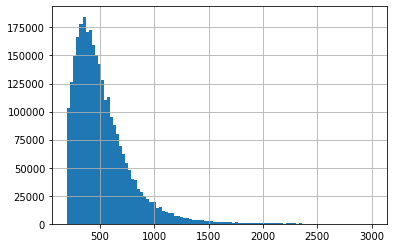

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.955910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8149
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 358


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6288
[100]	valid_0's huber: 64.9644
[150]	valid_0's huber: 58.7218
[200]	valid_0's huber: 55.0433
[250]	valid_0's huber: 52.553
[300]	valid_0's huber: 50.7164
[350]	valid_0's huber: 49.3747
[400]	valid_0's huber: 48.2673
[450]	valid_0's huber: 47.4522
[500]	valid_0's huber: 46.6175
[550]	valid_0's huber: 45.9052
[600]	valid_0's huber: 45.1702
[650]	valid_0's huber: 44.6041
[700]	valid_0's huber: 44.1038
[750]	valid_0's huber: 43.6454
[800]	valid_0's huber: 43.2989
[850]	valid_0's huber: 42.856
[900]	valid_0's huber: 42.5078
[950]	valid_0's huber: 42.1806
[1000]	valid_0's huber: 41.862
[1050]	valid_0's huber: 41.5735
[1100]	valid_0's huber: 41.2942
[1150]	valid_0's huber: 41.0716
[1200]	valid_0's huber: 40.8818
[1250]	valid_0's huber: 40.6253
[1300]	valid_0's huber: 40.4352
[1350]	valid_0's huber: 40.2394
[1400]	valid_0's huber: 40.0158
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


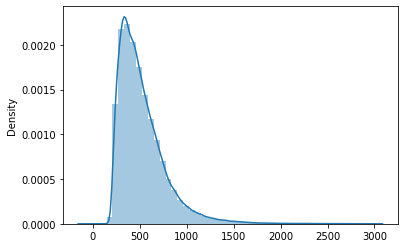

Fold 0 end
Fold 1 start
(2926581, 359)
y dist plot


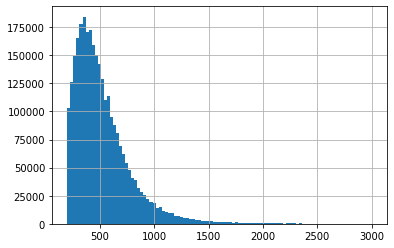

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.979094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8151
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 359


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6252
[100]	valid_0's huber: 64.6825
[150]	valid_0's huber: 58.5266
[200]	valid_0's huber: 54.9454
[250]	valid_0's huber: 52.3412
[300]	valid_0's huber: 50.724
[350]	valid_0's huber: 49.2818
[400]	valid_0's huber: 48.1219
[450]	valid_0's huber: 47.2478
[500]	valid_0's huber: 46.5125
[550]	valid_0's huber: 45.8074
[600]	valid_0's huber: 45.1427
[650]	valid_0's huber: 44.6039
[700]	valid_0's huber: 44.0357
[750]	valid_0's huber: 43.5413
[800]	valid_0's huber: 43.1152
[850]	valid_0's huber: 42.751
[900]	valid_0's huber: 42.405
[950]	valid_0's huber: 42.1058
[1000]	valid_0's huber: 41.823
[1050]	valid_0's huber: 41.5224
[1100]	valid_0's huber: 41.2775
[1150]	valid_0's huber: 41.076
[1200]	valid_0's huber: 40.8523
[1250]	valid_0's huber: 40.6134
[1300]	valid_0's huber: 40.4013
[1350]	valid_0's huber: 40.1883
[1400]	valid_0's huber: 39.9952
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


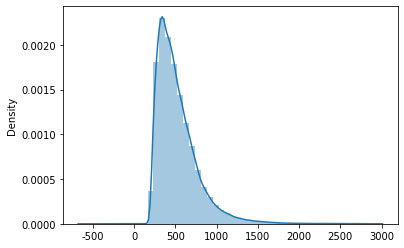

Fold 1 end
Fold 2 start
(2926581, 359)
y dist plot


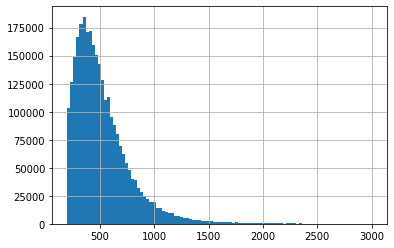

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.980701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8158
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 358


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4786
[100]	valid_0's huber: 64.7828
[150]	valid_0's huber: 58.5695
[200]	valid_0's huber: 54.9794
[250]	valid_0's huber: 52.4857
[300]	valid_0's huber: 50.5867
[350]	valid_0's huber: 49.1561
[400]	valid_0's huber: 48.0736
[450]	valid_0's huber: 47.1751
[500]	valid_0's huber: 46.3456
[550]	valid_0's huber: 45.5455
[600]	valid_0's huber: 44.8563
[650]	valid_0's huber: 44.3277
[700]	valid_0's huber: 43.7762
[750]	valid_0's huber: 43.3508
[800]	valid_0's huber: 42.9508
[850]	valid_0's huber: 42.6101
[900]	valid_0's huber: 42.2909
[950]	valid_0's huber: 41.9731
[1000]	valid_0's huber: 41.7084
[1050]	valid_0's huber: 41.3922
[1100]	valid_0's huber: 41.1327
[1150]	valid_0's huber: 40.8455
[1200]	valid_0's huber: 40.6021
[1250]	valid_0's huber: 40.3843
[1300]	valid_0's huber: 40.1435
[1350]	valid_0's huber: 39.9457
[1400]	valid_0's huber: 39.7573
[1450]	

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


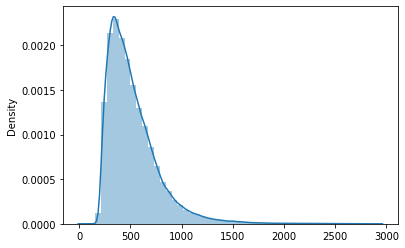

Fold 2 end
Fold 3 start
(2926581, 359)
y dist plot


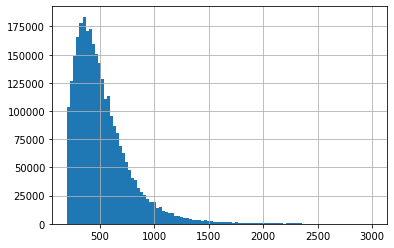

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.940749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 359


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4318
[100]	valid_0's huber: 64.7912
[150]	valid_0's huber: 58.5785
[200]	valid_0's huber: 54.9014
[250]	valid_0's huber: 52.4135
[300]	valid_0's huber: 50.7386
[350]	valid_0's huber: 49.4192
[400]	valid_0's huber: 48.2806
[450]	valid_0's huber: 47.3697
[500]	valid_0's huber: 46.4881
[550]	valid_0's huber: 45.7606
[600]	valid_0's huber: 45.1031
[650]	valid_0's huber: 44.6114
[700]	valid_0's huber: 44.1028
[750]	valid_0's huber: 43.6412
[800]	valid_0's huber: 43.208
[850]	valid_0's huber: 42.8696
[900]	valid_0's huber: 42.5327
[950]	valid_0's huber: 42.1971
[1000]	valid_0's huber: 41.8912
[1050]	valid_0's huber: 41.612
[1100]	valid_0's huber: 41.3294
[1150]	valid_0's huber: 41.0158
[1200]	valid_0's huber: 40.7778
[1250]	valid_0's huber: 40.549
[1300]	valid_0's huber: 40.3179
[1350]	valid_0's huber: 40.1109
[1400]	valid_0's huber: 39.9384
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


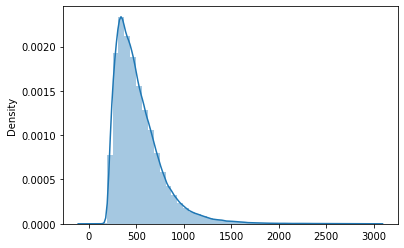

Fold 3 end
Fold 4 start
(2926581, 359)
y dist plot


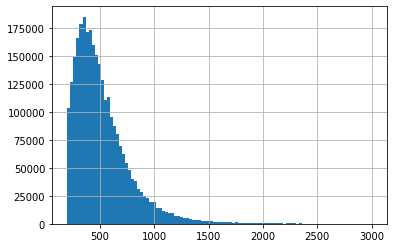

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.929412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8151
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 359


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.295
[100]	valid_0's huber: 64.5553
[150]	valid_0's huber: 58.467
[200]	valid_0's huber: 54.8178
[250]	valid_0's huber: 52.467
[300]	valid_0's huber: 50.6828
[350]	valid_0's huber: 49.2591
[400]	valid_0's huber: 48.1208
[450]	valid_0's huber: 47.1508
[500]	valid_0's huber: 46.4476
[550]	valid_0's huber: 45.7596
[600]	valid_0's huber: 45.071
[650]	valid_0's huber: 44.4935
[700]	valid_0's huber: 43.9924
[750]	valid_0's huber: 43.5449
[800]	valid_0's huber: 43.1353
[850]	valid_0's huber: 42.7321
[900]	valid_0's huber: 42.4006
[950]	valid_0's huber: 42.1055
[1000]	valid_0's huber: 41.7727
[1050]	valid_0's huber: 41.4598
[1100]	valid_0's huber: 41.1717
[1150]	valid_0's huber: 40.8906
[1200]	valid_0's huber: 40.6577
[1250]	valid_0's huber: 40.4628
[1300]	valid_0's huber: 40.2515
[1350]	valid_0's huber: 40.0459
[1400]	valid_0's huber: 39.8404
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


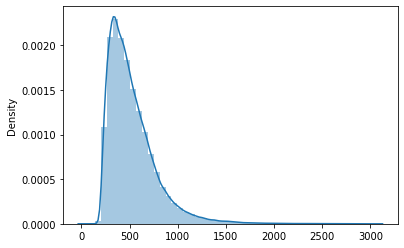

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [26]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=cols_to_drop)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=cols_to_drop)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_over_zero_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

66.20962030354343

In [29]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [30]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [31]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [32]:
shap_summary_df.index = x_train.columns

In [33]:
shap_summary_df.to_csv(basedir + 'shap_over_zero_summary.csv')